In [6]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sns.set_palette("pastel")

In [7]:
# Cargar los datos
train = pd.read_csv("data/train.csv")

In [8]:
train.rename(columns={
    'Working Professional or Student': 'Work_Stud',
    'Academic Pressure': 'Press_Acad',
    'Work Pressure': 'Press_Lab',
    'Study Satisfaction': 'Stud_Satisfac',
    'Job Satisfaction': 'Job_Satisfac',
    'Sleep Duration': 'Sleep_Dur',
    'Dietary Habits': 'Diet_Hab',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Work/Study Hours': 'Work_Study_Hrs',
    'Financial Stress': 'Financial_stress',
    'Family History of Mental Illness': 'Fam_His_MH'
}, inplace=True)

In [9]:
# Limpieza y normalización de la columna Profession
train['Profession'] = train['Profession'].str.strip().str.lower()
train['Profession'] = train['Profession'].fillna('unknown')

#  ---------------------------------------------------------------------------------
# Diccionario para mapear valores válidos
sleep_dur_map = {
    'more than 8 hours': 9,
    'less than 5 hours': 4.5,
    '5-6 hours': 5.5,
    '7-8 hours': 7.5,
    '1-2 hours': 2,
    '6-8 hours': 7,
    '4-6 hours': 5,
    '6-7 hours': 6.5,
    '10-11 hours': 10.5,
    '8-9 hours': 8.5,
    '9-11 hours': 10,
    '2-3 hours': 2.5,
    '3-4 hours': 3.5,
    '4-5 hours': 4.5,
    '9-6 hours': 7.5,  # Interpretado como 7.5 horas
    '1-3 hours': 2,
    '1-6 hours': 3.5,  # Promedio de 1 y 6 horas
    '3-6 hours': 4.5,  # Promedio de 3 y 6 horas
    '40-45 hours': None,  # Dato inconsistente
    '55-66 hours': None,  # Dato inconsistente
    '45-48 hours': None,  # Dato inconsistente
    '49 hours': None,  # Dato inconsistente
    'than 5 hours': 5,  # Asumimos "5 horas"
    '8 hours': 8,  # Asumimos 8 horas
    '10-6 hours': 8,  # Asumimos el promedio entre 10 y 6 horas
    '9-5 hours': 7,  # Interpretado como 7 horas
    'sleep_duration': None,  # Irrelevante
    'no': None,  # Irrelevante
    'indore': None,  # Irrelevante
    'pune': None,  # Irrelevante
    'unhealthy': None,  # Irrelevante
    'work_study_hours': None  # Irrelevante
}

# Mapear los valores a horas numéricas
train['Sleep_Dur'] = train['Sleep_Dur'].str.lower().map(sleep_dur_map)
# Calcular el promedio de las horas de sueño limpias
mean_sleep = train['Sleep_Dur'].median(skipna=True)
# Reemplazar valores faltantes con el promedio
train['Sleep_Dur'] = train['Sleep_Dur'].fillna(mean_sleep)

#  ---------------------------------------------------------------------------------
# Diccionario para mapear valores válidos
diet_map = {
    'healthy': 'Healthy',
    'more healthy': 'Healthy',
    'less healthy': 'Unhealthy',
    'unhealthy': 'Unhealthy',
    'moderate': 'Moderate',
    'no healthy': 'Unhealthy',
    'yes': 'Moderate',  # Suposición basada en contexto
    'no': 'Unhealthy',  # Suposición basada en contexto
    '2': 'Moderate',  # Suposición basada en datos
    '1.0': 'Moderate',  # Suposición basada en datos
    '3': 'Moderate',  # Suposición basada en datos
    # Irrelevantes o inconsistentes
    'pratham': None,
    'bsc': None,
    'gender': None,
    'mihir': None,
    'hormonal': None,
    'electrician': None,
    'm.tech': None,
    'vegas': None,
    'male': None,
    'indoor': None,
    'class 12': None
}

# Normalizar y mapear los valores
train['Diet_Hab'] = train['Diet_Hab'].str.lower().map(diet_map)
# Reemplazar valores faltantes con la categoría más frecuente
most_frequent_diet = train['Diet_Hab'].mode()[0]  # Categoría más frecuente
train['Diet_Hab'] = train['Diet_Hab'].fillna(most_frequent_diet)

#  ---------------------------------------------------------------------------------
# Diccionario de mapeo para títulos académicos
degree_map = {
    # Bachillerato
    'class 12': 'High School',
    'class 11': 'High School',
    # Grados
    'bsc': 'Bachelor',
    'bca': 'Bachelor',
    'be': 'Bachelor',
    'b.arch': 'Bachelor',
    'bcom': 'Bachelor',
    'b.ba': 'Bachelor',
    'b.pharm': 'Bachelor',
    'b.tech': 'Bachelor',
    'b.ed': 'Bachelor',
    'ba': 'Bachelor',
    # Maestrías
    'mca': 'Master',
    'mba': 'Master',
    'm.tech': 'Master',
    'm.ed': 'Master',
    'm.sc': 'Master',
    'm.com': 'Master',
    'm.pharm': 'Master',
    # Doctorados
    'phd': 'Doctorate',
    'md': 'Doctorate',
    # Otros
    'ux/ui designer': 'Other',
    'plumber': 'Other',
    'electrician': 'Other',
    # Valores irrelevantes
    'bhavesh': None,
    'brit': None,
    '5.61': None,
    '0': None
}

# Normalizar la columna Degree
train['DegreeF'] = train['Degree'].str.lower().str.strip().map(degree_map)
# Completar valores faltantes con "Unknown"
train['DegreeF'] = train['DegreeF'].fillna('Unknown')

#  ---------------------------------------------------------------------------------
# Crear una columna con niveles educativos
education_level_map = {
    'High School': 1,
    'Bachelor': 2,
    'Master': 3,
    'Doctorate': 4,
    'Other': 0,
    'Unknown': -1
}

train['Education_Level'] = train['DegreeF'].map(education_level_map)

In [10]:
# Imputación de valores faltantes (si es necesario)
for col in ['Press_Lab', 'CGPA', 'Stud_Satisfac', 'Press_Acad', 'Job_Satisfac', 'Financial_stress']:
    train[col] = train[col].fillna(train[col].median())  # Usar la mediana para valores faltantes

In [11]:
# Creación de nuevas variables
train['Combined_Stress'] = train['Press_Acad'].fillna(3) + \
                           train['Press_Lab'].fillna(3) + \
                           train['Financial_stress'].fillna(3)

train['Mean_Satisfac'] = train[['Job_Satisfac', 'Stud_Satisfac']].mean(axis=1)

train['Sleep_Deficit'] = (train['Sleep_Dur'] < 6).astype(int)

In [12]:
train = train.drop(columns=['id' ,'Name', 'City', 'Degree'])

In [13]:
# Codificación One-Hot para variables categóricas con pocas categorías
categorical_vars = ['Gender', 'Work_Stud', 'Diet_Hab', 'Suicidal_Thoughts', 'Fam_His_MH']
train = pd.get_dummies(train, columns=categorical_vars, drop_first=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

# Codificación Label Encoding para 'Profession'
le = LabelEncoder()
train['Profession'] = le.fit_transform(train['Profession'])
train['DegreeF'] = le.fit_transform(train['DegreeF'])

In [15]:
from sklearn.preprocessing import StandardScaler

# Escalar variables numéricas continuas
numerical_vars = ['Age', 'CGPA', 'Sleep_Dur', 'Work_Study_Hrs']
scaler = StandardScaler()
train[numerical_vars] = scaler.fit_transform(train[numerical_vars])

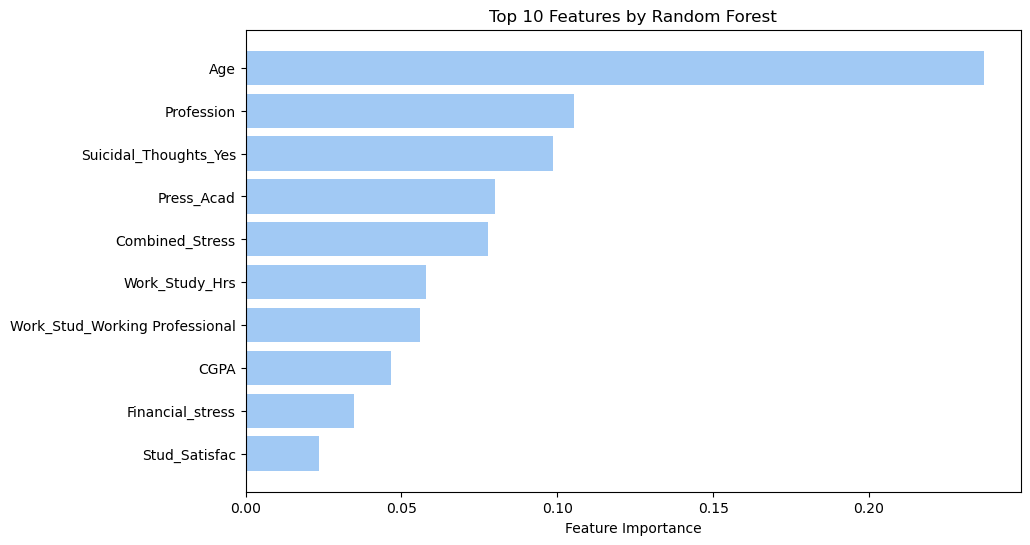

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Separar variables independientes y dependientes
X = train.drop(columns=['Depression'])
y = train['Depression']

# Entrenar un modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Obtener importancia de las características
importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)

# Visualizar las características más importantes
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'][:10][::-1], importances['Importance'][:10][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features by Random Forest')
plt.show()

Modelo: Logistic Regression
Accuracy: 0.9377
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.81      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140

--------------------------------------------------
Modelo: Random Forest
Accuracy: 0.9351
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     23027
           1       0.84      0.79      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.94      0.93     28140

--------------------------------------------------
Modelo: Gradient Boosting
Accuracy: 0.9375
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
        

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:28:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modelo: XGBoost
Accuracy: 0.9382
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.81      0.83      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140

--------------------------------------------------


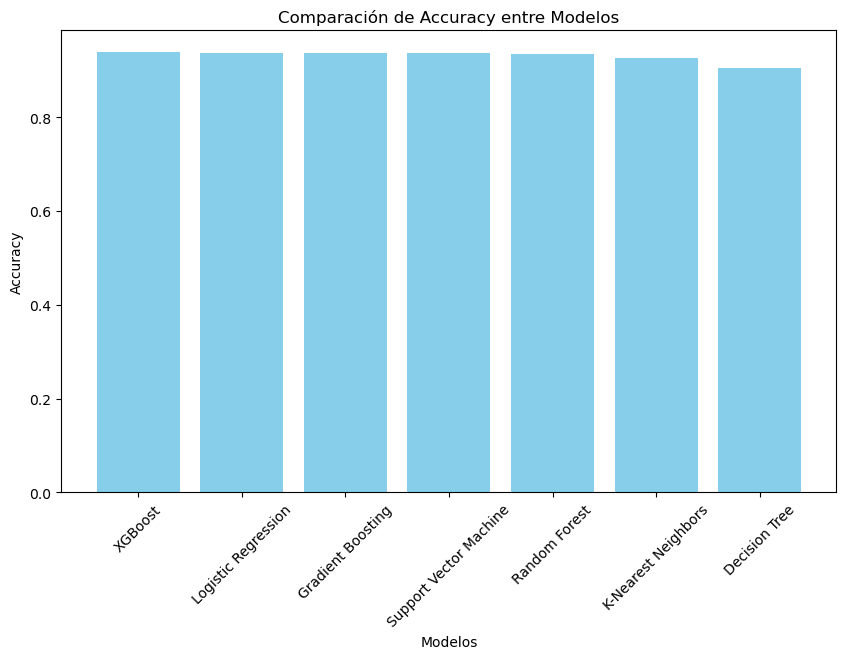

In [12]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier  # Importar XGBoost

# Paso 1: Cargar y dividir los datos
# Suponiendo que ya tienes un DataFrame 'train' con las transformaciones realizadas
X = train.drop(columns=['Depression'])  # Variables independientes
y = train['Depression']  # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables numéricas (si es necesario)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Paso 2: Definir los modelos a probar
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)  # XGBoost incluido
}

# Paso 3: Entrenar y evaluar cada modelo
accuracy_scores = {}

for name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = accuracy
    
    # Imprimir clasificación
    print(f"Modelo: {name}")
    print(f"Accuracy: {accuracy:.8f}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Paso 4: Visualizar los resultados
import matplotlib.pyplot as plt

# Ordenar resultados por accuracy
accuracy_scores = dict(sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True))

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.xticks(rotation=45)
plt.show()


In [64]:
# Ajustar XGBoost para mejorar el rendimiento
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Definir el modelo base con parámetros iniciales
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Realizar Grid Search con validación cruzada
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación en el conjunto de prueba
y_pred = best_xgb.predict(X_test)
print("Accuracy en validación:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Accuracy en validación: 0.9392324093816631
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.85      0.81      0.83      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140



In [27]:
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier
from GPyOpt.methods import BayesianOptimization
from sklearn.metrics import accuracy_score

# Paso 1: Cargar y dividir los datos
# Suponiendo que ya tienes un DataFrame 'train' con las transformaciones realizadas
X = train.drop(columns=['Depression'])  # Variables independientes
y = train['Depression']  # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Escalar variables numéricas (si es necesario)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Definir el espacio de búsqueda para los hiperparámetros
bds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.01, 0.3)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5, 7, 9, 11)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 100, 150, 200, 300)},
    {'name': 'subsample', 'type': 'continuous', 'domain': (0.6, 1.0)},
    {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0.6, 1.0)}
]

# Definir la función objetivo para la optimización bayesiana
def cv_score(params):
    params = params[0]
    model = XGBClassifier(
        learning_rate=params[0],
        max_depth=int(params[1]),
        n_estimators=int(params[2]),
        subsample=params[3],
        colsample_bytree=params[4],
        eval_metric='logloss',
        random_state=42
    )
    
    # Evaluación cruzada para obtener la métrica (accuracy)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=15)
    return scores.mean()

# Inicializar la optimización bayesiana
optimizer = BayesianOptimization(
    f=cv_score,
    domain=bds,
    model_type='GP',
    acquisition_type='EI',
    acquisition_jitter=0.05,
    exact_feval=True,
    maximize=True
)

# Correr la optimización (10 iteraciones iniciales, 50 de mejora)
optimizer.run_optimization(max_iter=50, verbosity=True)

# Mejor conjunto de hiperparámetros encontrado
print("Mejores hiperparámetros encontrados:")
print(f"Learning Rate: {optimizer.X[-1][0]:.4f}")
print(f"Max Depth: {int(optimizer.X[-1][1])}")
print(f"N Estimators: {int(optimizer.X[-1][2])}")
print(f"Subsample: {optimizer.X[-1][3]:.4f}")
print(f"Colsample Bytree: {optimizer.X[-1][4]:.4f}")

# Entrenar el modelo final con los mejores hiperparámetros
best_params = optimizer.X[-1]
best_xgb = XGBClassifier(
    learning_rate=best_params[0],
    max_depth=int(best_params[1]),
    n_estimators=int(best_params[2]),
    subsample=best_params[3],
    colsample_bytree=best_params[4],
    eval_metric='logloss',
    random_state=42
)
best_xgb.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = best_xgb.predict(X_test)
print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))


num acquisition: 1, time elapsed: 3.41s
num acquisition: 2, time elapsed: 7.01s
num acquisition: 3, time elapsed: 10.59s
num acquisition: 4, time elapsed: 14.16s
num acquisition: 5, time elapsed: 23.43s
num acquisition: 6, time elapsed: 33.22s
num acquisition: 7, time elapsed: 42.92s
num acquisition: 8, time elapsed: 52.51s
num acquisition: 9, time elapsed: 62.01s
num acquisition: 10, time elapsed: 71.87s
num acquisition: 11, time elapsed: 80.92s
num acquisition: 12, time elapsed: 89.74s
num acquisition: 13, time elapsed: 102.02s
num acquisition: 14, time elapsed: 113.70s
num acquisition: 15, time elapsed: 126.70s
num acquisition: 16, time elapsed: 138.54s
num acquisition: 17, time elapsed: 151.07s
num acquisition: 18, time elapsed: 157.34s
num acquisition: 19, time elapsed: 163.36s
num acquisition: 20, time elapsed: 169.60s
num acquisition: 21, time elapsed: 175.64s
num acquisition: 22, time elapsed: 181.89s
num acquisition: 23, time elapsed: 188.29s
num acquisition: 24, time elapsed:

In [ ]:
test = pd.read_csv('data/test.csv')

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Paso 1: Renombrar columnas en el conjunto de prueba
test.rename(columns={
    'Working Professional or Student': 'Work_Stud',
    'Academic Pressure': 'Press_Acad',
    'Work Pressure': 'Press_Lab',
    'Study Satisfaction': 'Stud_Satisfac',
    'Job Satisfaction': 'Job_Satisfac',
    'Sleep Duration': 'Sleep_Dur',
    'Dietary Habits': 'Diet_Hab',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Work/Study Hours': 'Work_Study_Hrs',
    'Financial Stress': 'Financial_stress',
    'Family History of Mental Illness': 'Fam_His_MH'
}, inplace=True)

In [30]:
# Limpieza y normalización de la columna Profession
test['Profession'] = test['Profession'].str.strip().str.lower()
test['Profession'] = test['Profession'].fillna('unknown')
# Mapear los valores a horas numéricas
test['Sleep_Dur'] = test['Sleep_Dur'].str.lower().map(sleep_dur_map)
# Calcular el promedio de las horas de sueño limpias
median_sleep = test['Sleep_Dur'].median(skipna=True)
# Reemplazar valores faltantes con el promedio
test['Sleep_Dur'] = test['Sleep_Dur'].fillna(median_sleep)
# Normalizar y mapear los valores
test['Diet_Hab'] = test['Diet_Hab'].str.lower().map(diet_map)
# Reemplazar valores faltantes con la categoría más frecuente
most_frequent_diet = test['Diet_Hab'].mode()[0]  # Categoría más frecuente
test['Diet_Hab'] = test['Diet_Hab'].fillna(most_frequent_diet)

# Normalizar la columna Degree
test['DegreeF'] = test['Degree'].str.lower().str.strip().map(degree_map)
# Completar valores faltantes con "Unknown"
test['DegreeF'] = test['DegreeF'].fillna('Unknown')

test['Education_Level'] = test['DegreeF'].map(education_level_map)

In [31]:
# Imputación de valores faltantes (si es necesario)
for col in ['Press_Lab', 'CGPA', 'Stud_Satisfac', 'Press_Acad', 'Job_Satisfac', 'Financial_stress']:
    test[col] = test[col].fillna(test[col].median())  # Usar la mediana para valores faltantes

In [32]:
# Creación de nuevas variables
test['Combined_Stress'] = test['Press_Acad'].fillna(3) + \
                           test['Press_Lab'].fillna(3) + \
                           test['Financial_stress'].fillna(3)

test['Mean_Satisfac'] = test[['Job_Satisfac', 'Stud_Satisfac']].mean(axis=1)

test['Sleep_Deficit'] = (test['Sleep_Dur'] < 6).astype(int)

In [33]:
# Codificación One-Hot para variables categóricas con pocas categorías
categorical_vars = ['Gender', 'Work_Stud', 'Diet_Hab', 'Suicidal_Thoughts', 'Fam_His_MH']
test = pd.get_dummies(test, columns=categorical_vars, drop_first=True)

In [34]:
from sklearn.preprocessing import LabelEncoder

# Codificación Label Encoding para 'Profession'
le = LabelEncoder()
test['Profession'] = le.fit_transform(test['Profession'])
test['DegreeF'] = le.fit_transform(test['DegreeF'])

In [35]:
from sklearn.preprocessing import StandardScaler

# Escalar variables numéricas continuas
numerical_vars = ['Age', 'CGPA', 'Sleep_Dur', 'Work_Study_Hrs']
scaler = StandardScaler()
test[numerical_vars] = scaler.fit_transform(test[numerical_vars])

In [36]:
# Asegurarse de que todas las columnas sean del tipo correcto
test = test.select_dtypes(include=[np.number, 'bool', 'category'])

# Alinear las columnas del conjunto de prueba con las del conjunto de entrenamiento
X_train_columns = X.columns
test = test.reindex(columns=X_train_columns, fill_value=0)

test['Depression'] = best_xgb.predict(test)

# Paso 5: Crear archivo de salida
submission = pd.DataFrame({
    'id': pd.read_csv('data/test.csv')['id'],  # Recuperar columna 'id' original
    'Depression': test['Depression']
})

# Guardar archivo CSV para Kaggle
submission.to_csv('submission_BOpt.csv', index=False)
print("Archivo 'submission_BOpt.csv' creado con éxito.")


Archivo 'submission_BOpt.csv' creado con éxito.
